In [2]:
from custom_dataset import *
from models import *
from saveAndLoad import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.datasets import load_iris
import pandas as pd
from sklearn.cluster import KMeans

# LOAD DATA
data_dir = '../labeled_data/'
labeled_data = os.listdir(data_dir)
for ni,i in sorted(zip(labeled_data,range(len(labeled_data)))):print(i,'\t',ni)

mut_embeddings = np.load('../aa/canonical_mut_average_embeddings_esm2.npy')
ref_embeddings = np.load('../aa/canonical_ref_embeddings_esm2.npy')
tumors = pickleLoad('../aa/tumors.pkl')
assays = pickleLoad('../aa/assays.pkl')
output = pickleLoad('./tsne_output.pkl')
class Config_Bin:
    n_labels: int
    input_dim: int = 1448
    bias: bool = False
    
class Config_Att:
    n_labels: int
    n_layer: int = 3
    input_dim: int = 640
    dropout: float = 0.0
    bias: bool = False
    pooling : str = 'mean'
    norm_fn: nn.Module = nn.LayerNorm
    max_len : int = 1448
    position_embedding: bool = False
    num_heads: int = 1

/home/dandreas/.conda/envs/deepV_a100/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/dandreas/.conda/envs/deepV_a100/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


0 	 data_0_00_survival_ratio1.csv
1 	 data_0_00percentMinCancerType.csv
2 	 data_0_10percentMinCancerType.csv
4 	 data_1_00percentMinCancerType.csv
3 	 label_mappings
loading data from ../aa/tumors.pkl
loading data from ../aa/assays.pkl
loading data from ./tsne_output.pkl


In [3]:
def test_survival(model,test_loader,binary = False, get_embeddings = False, days_alive = False, label_map=None):
    # Evaluation
    all_times = []
    all_events = []
    all_risks = []
    all_embeddings = []
    model.eval()
    with torch.no_grad():
        for i in tqdm(test_loader,desc='TESTING'):
            if binary:
                data, time, event = i
                if get_embeddings:
                    output, embeddings = model(data, return_embedding = True)
                    all_embeddings.extend(embeddings.cpu().numpy())
                else: output = model(data)
            else:
                data, positions, time, event = i
                if get_embeddings:
                    output, embeddings = model(data, positions, return_embedding = True)
                    all_embeddings.extend(embeddings.cpu().numpy())
                else:
                    output = model(data, positions)
            risk = output.squeeze()
            all_risks.extend(risk.cpu().numpy())
            all_times.extend(time.cpu().numpy())
            all_events.extend(event.cpu().numpy())
    survival = np.column_stack((all_times, all_events))
    c_index_value = c_index(np.array(all_risks), survival)
    print('C-index:',c_index_value)
    if get_embeddings:
        return c_index_value, np.array(all_embeddings, dtype=np.float32), all_risks, pd.DataFrame(survival, columns=['Time', 'Event'])
    return c_index_value

def test_tumortype(model,test_loader,binary = False, get_embeddings = False, label_map = None, days_alive = None):
    # Evaluation
    model.eval()
    correct = 0
    total = 0
    all_embeddings = []
    all_predicted = []
    all_logits = []
    with torch.no_grad():
        for i in tqdm(test_loader,desc='TESTING'):
            if binary:
                data, target = i
                if get_embeddings:
                    output, embeddings = model(data, return_embedding = True)
                    all_embeddings.extend(embeddings.cpu().numpy())
                else:
                    output = model(data)
            else:
                data, positions, target = i
                if get_embeddings:
                    output, embeddings = model(data, positions, return_embedding = True)
                    all_embeddings.extend(embeddings.cpu().numpy())
                else:
                    output = model(data, positions)
            all_logits.extend(output.cpu().numpy())
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            all_predicted.extend(predicted.cpu().numpy())
    
    map_fn = lambda x: label_map[x]
    all_predicted = np.vectorize(map_fn)(all_predicted)
    accuracy = correct / total
    print('Accuracy:',100*accuracy)
    if get_embeddings:
        return accuracy, np.array(all_embeddings, dtype=np.float32), all_predicted, all_logits
    return accuracy

def test(data_filename, label_col, binary, survival=False, device='cuda:1', get_embeddings= False, label_map = None, days_alive = False):
    print(data_filename)
    label_str = label_col.split('_INT')[0]
    data_df = pd.read_csv(data_dir+data_filename)
    nlabels = len(data_df[label_col].unique())

    loaders_binary =        lambda x: getTrainTestLoaders(x, batch_size = 500, return_indices=True)
    loaders_assay_surv =    lambda x: getTrainTestLoaders(x, batch_size = 500, collate=custom_collate_assay_survival, return_indices=True)
    loaders_assay_ttype =   lambda x: getTrainTestLoaders(x, batch_size = 500, collate=custom_collate_assay, return_indices=True)

    config = Config_Bin()                    if binary   else Config_Att()
    config.n_labels = 1                      if survival else nlabels
    model = MLPClassifier(config)            if binary   else Classifier(config)
    m_str = 'binary'                         if binary   else 'sha'   
    modelname = f'model_{m_str}_survival.pt' if survival else f'model_{m_str}_{label_col}_{data_filename.split(".")[0]}.pt'
    test_fn = test_survival                  if survival else lambda model, test_loader, binary, get_embeddings, days_alive: test_tumortype(model, test_loader, binary = binary, get_embeddings = get_embeddings, label_map=label_map)
    print('n labels:',config.n_labels)
    
    if binary:
        if survival: 
            dataset = Dataset_Binary_Survival(data_df, device)
        else: 
            dataset = Dataset_Binary(data_df, label_col, device)
        loader = loaders_binary
    else:
        if survival: 
            dataset = Dataset_Assay_Survival(data_df, mut_embeddings, ref_embeddings, tumors, assays, device)
            loader = loaders_assay_surv
        else: 
            dataset = Dataset_Assay(data_df,label_col,mut_embeddings,ref_embeddings,tumors,assays,device)
            loader = loaders_assay_ttype

    _, test_loader, _, test_indices = loader(dataset)
    labels = data_df[label_str].iloc[test_indices]
    detailed = data_df['CANCER_TYPE_DETAILED'].iloc[test_indices]
    model.load_state_dict(torch.load(f'./best_models/{modelname}'))
    model.to(device)
    return test_fn(model, test_loader, binary=binary, get_embeddings=get_embeddings, days_alive = days_alive), labels.to_numpy(), detailed.to_numpy()

def get_tsne(embeddings):
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne  = tsne.fit_transform(embeddings)
    return X_tsne

def plot_tsne(X_tsne, predictions, labels, detailed = None, subset_labels=None, survival=False, days_alive=None, stratify = None, save_name=None):
    df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
    df_tsne['label'] = labels
    if detailed is not None:
        df_tsne['Detailed'] = detailed
        df_tsne['Detailed Counts'] = df_tsne['Detailed'].map(df_tsne['Detailed'].value_counts())
    if days_alive is not None:
        df_tsne['Class'] = days_alive['Time']
        df_tsne = df_tsne[days_alive['Event'] == 1]
        df_tsne = df_tsne[df_tsne['Class'] < 5000]
    elif survival:
        df_tsne['Class'] = predictions
        if stratify is not None:
            bins = stratify
            df_tsne['Class'] = pd.cut(predictions, bins=bins, labels=bins[:-1], right = False)
    else:
        df_tsne['Class'] = labels if detailed is None else detailed

    # Filter the DataFrame if subset_labels is provided
    if subset_labels is not None:
        df_tsne = df_tsne[df_tsne['label'].isin(subset_labels)]

    if detailed is not None:
        df_tsne = df_tsne[df_tsne['Detailed Counts'] > 10]
    
    # Generate the t-SNE plot
    plt.figure(figsize=(5, 4))
    fs=14
    if survival:
        scatter = plt.scatter(
            df_tsne['TSNE1'], df_tsne['TSNE2'],
            c = df_tsne['Class'], cmap = 'viridis', alpha = 1, s=1,
        )
        if stratify is not None:
            handles = [
                plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(0.25), markersize=10, label='Low'),
                plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(0.75), markersize=10, label='High'),
                plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(0.99), markersize=10, label='Very High'),
            ]
            plt.legend(handles=handles, loc='upper right', fontsize = fs)
        else:
            cbar = plt.colorbar(scatter)
            cbar.set_label('Risk', fontsize=fs)
            
            # Values at which to draw horizontal lines
            line_values =[6.38, 8.07]

            # Get the colorbar's axis
            cbar_ax = cbar.ax

            # Draw horizontal lines on the colorbar
            for value in line_values:
                cbar_ax.axhline(value, color='red', linewidth=2)   
        plt.xlabel('t-SNE 1',fontsize = fs)
        plt.ylabel('t-SNE 2',fontsize = fs)
        plt.xticks([])
        plt.yticks([])
    else:
        scatter = sns.scatterplot(
            x="TSNE1", y="TSNE2",
            hue="Class",
            palette=sns.color_palette("bright", n_colors=len(np.unique(df_tsne['Class']))),
            data=df_tsne,
            legend="full",
            alpha=1
        )
        plt.legend(bbox_to_anchor=(1,1))
    if save_name is not None:
        plt.savefig(save_name)
    plt.show()

def plot_cluster(data_df, save_name=None):
    plt.figure(figsize=(4, 4))
    fs=14
    scatter = plt.scatter(
        data_df['TSNE1'], data_df['TSNE2'],
        c = data_df['Majority Risk Values'], cmap = 'viridis', alpha = 1, s = 1
    )
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(0.25), markersize=10, label='Low'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(0.75), markersize=10, label='High'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(0.99), markersize=10, label='Very High'),
    ]
    plt.legend(handles=handles, bbox_to_anchor=(.32,.8), fontsize=8, frameon=False, facecolor='none')
    plt.xlabel('t-SNE 1',fontsize=fs)
    plt.ylabel('t-SNE 2',fontsize=fs)
    plt.xticks([])
    plt.yticks([])

    if save_name is not None:
        plt.savefig(save_name)


In [4]:
def save_output(output, label_col, binary, data, survival, outputtype):
    print(data)
    modeltype = 'binary' if binary else 'somatt'
    label_str = label_col.split('_INT')[0]
    label_map = pickleLoad(f'../labeled_data/label_mappings/label_mapping_{label_str}{data.split(".")[0]}.pkl')
    if 'tumortype' not in outputtype:
        (metric, embeddings, predictions, time_event), labels, detailed = test(data, label_col, binary, survival=survival, get_embeddings=True, label_map = label_map)
        output[(modeltype,outputtype)] = metric,embeddings,predictions,time_event,labels,detailed, get_tsne(embeddings)
    else:
        (metric, embeddings, predictions, logits), labels, detailed = test(data, label_col, binary, survival=survival, get_embeddings=True, label_map = label_map)
        output[(modeltype,outputtype)] = metric,embeddings,predictions,logits,label_map,labels,detailed, get_tsne(embeddings)
    # pickleSave(output,'./','tsne_output.pkl')
    return output

t = 'CANCER_TYPE_INT'

data = labeled_data[0]

b = True
output = save_output(output, t, b, data, survival=True, outputtype='survival')
b = False
output = save_output(output, t, b, data, survival=True, outputtype='survival')

# data = labeled_data[1]
# b = True
# output = save_output(output, t, b, data, survival=False, outputtype='tumortype')
# b = False
# output = save_output(output, t, b, data, survival=False, outputtype='tumortype')

# data = labeled_data[4]
# b = True
# output = save_output(output, t, b, data, survival=False, outputtype='tumortype1')
# b = False
# output = save_output(output, t, b, data, survival=False, outputtype='tumortype1')


data_0_00_survival_ratio1.csv
Load failed. File does not exist: ../labeled_data/label_mappings/label_mapping_CANCER_TYPEdata_0_00_survival_ratio1.pkl
data_0_00_survival_ratio1.csv
n labels: 1
43338 samples
41481 unique patients
90 cancer types
626 detailed cancer types


/tmp/ipykernel_2479597/1997913267.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./best_models/{modelname}'))
TESTING: 100%|███████

C-index: 0.7118832648728811


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5a1cc6cf70>
Traceback (most recent call last):
  File "/home/dandreas/.conda/envs/deepV_a100/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/dandreas/.conda/envs/deepV_a100/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/dandreas/.conda/envs/deepV_a100/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/dandreas/.conda/envs/deepV_a100/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


data_0_00_survival_ratio1.csv
Load failed. File does not exist: ../labeled_data/label_mappings/label_mapping_CANCER_TYPEdata_0_00_survival_ratio1.pkl
data_0_00_survival_ratio1.csv
n labels: 1
43338 samples
41481 unique patients
90 cancer types
626 detailed cancer types


/tmp/ipykernel_2479597/1997913267.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./best_models/{modelname}'))
TESTING: 100%|███████

C-index: 0.7567461112614494


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f598be6fd90>
Traceback (most recent call last):
  File "/home/dandreas/.conda/envs/deepV_a100/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/dandreas/.conda/envs/deepV_a100/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/dandreas/.conda/envs/deepV_a100/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/dandreas/.conda/envs/deepV_a100/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


In [107]:
# days_alive_data['Risk'] = predictions
# days_alive_data['Cancer Type'] = labels
# days_alive_data.to_csv('SoMatt_Survival_Data_Uncensored_Full.csv',index=False)

# days_alive_data.sort_values('Risk',ascending=False)

In [108]:
# labels = days_alive_data
# survival = True
# df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
# df_tsne['Days Alive'] = labels['Time']
# df_tsne['Risk'] = predictions
# df_tsne_ = df_tsne[labels['Event'] == 1]
# df_tsne_ = df_tsne_[df_tsne_['Days Alive'] < 5000]

# # Generate the t-SNE plot
# plt.figure(figsize=(16, 10))

# scatter = plt.scatter(
#     df_tsne_['TSNE1'], df_tsne_['TSNE2'],
#     c = df_tsne_['Days Alive'], cmap = 'viridis', alpha = 1
# )
# cbar = plt.colorbar(scatter)
# cbar.set_label('Days Alive')
# plt.show()

In [109]:
# df_tsne_ = df_tsne_.sort_values('Risk',ascending=False)
# plt.scatter(df_tsne_['Days Alive'], df_tsne_['Risk'])
# plt.xlabel('Days Alive')
# plt.ylabel('Risk')
# plt.show()

In [110]:
# df_tsne_.sort_values('Days Alive', ascending=False)

In [111]:
# df_tsne_.value_counts('Days Alive').head(20)

In [7]:
import re
def create_exponential_ranges(start, end, num_bins, squeeze_factor=.16):
    # Create linearly spaced points between 0 and 1, adjusted by the squeeze factor
    linear_space = np.linspace(0, 1, num_bins+1)
    
    # Apply the exponential scaling (adjustable by the squeeze factor)
    scaled_space = np.power(linear_space, squeeze_factor)
    
    # Map the scaled values to the desired range [start, end]
    ranges = start + (end - start) * scaled_space
    
    return ranges

def clean_string(s):
    s = re.sub(r'[^a-zA-Z0-9\s]', '', s)
    s = re.sub(r'\s+', '_', s)
    return s

metric,embeddings,predictions,time_event,labels,detailed, X_tsne  = output[('somatt','survival')]
data_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
data_df['Risk'] = predictions
data_df['Cancer Type'] = labels
data_df['Detailed'] = detailed
data_df['Time'] = time_event['Time']    
data_df['Event'] = time_event['Event']
data_df.to_csv(f'./km/SoMatt_Survival_Data_Balanced_Full.csv',index=False)
nbins = 3
bins = create_exponential_ranges(min(predictions), max(predictions), nbins)
data_df['Risk'] = pd.cut(predictions, bins=bins, labels=bins[:-1], right = False)
# labelmap = {bins[0]:'low',bins[1]: 'medium', bins[2]: 'high', bins[3]: 'very high'}
labelmap = {bins[0]:'low',bins[1]: 'high', bins[2]: 'very high'}
print([(f'{l}',f'{i:.2f}') for i,l in labelmap.items()])
data_df['Risk Bins'] = data_df['Risk'].map(labelmap)
# snn = pickleLoad('snn_labs.pkl')
# labels = snn[(9,11)]
kmeans = KMeans(n_clusters=40, random_state=0)
labels = kmeans.fit_predict(X_tsne)
data_df['Cluster'] = labels
majority_risk = data_df.groupby('Cluster')['Risk Bins'].agg(lambda x: x.mode()[0])
data_df['Majority Risk'] = data_df['Cluster'].map(majority_risk)
majority_risk_vals = data_df.groupby('Cluster')['Risk'].agg(lambda x: x.mode()[0])
data_df['Majority Risk Values'] = data_df['Cluster'].map(majority_risk_vals)
for i in top99:
    data_df_cancer = data_df[data_df['Cancer Type'] == i]
    most_frequent_subtype = data_df_cancer['Detailed'].value_counts().idxmax()
    subtype_str = clean_string(most_frequent_subtype)
    print(subtype_str)
    data_df_cancer = data_df[data_df['Detailed']==most_frequent_subtype]
    print(data_df_cancer['Majority Risk'].value_counts())
    # print(data_df_cancer['Detailed'].value_counts())
    data_df_cancer.to_csv(f'./km/{subtype_str}_km60.csv')

/home/dandreas/.conda/envs/deepV_a100/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5baa12c5e0>
Traceback (most recent call last):
  File "/home/dandreas/.conda/envs/deepV_a100/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/dandreas/.conda/envs/deepV_a100/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/dandreas/.conda/envs/deepV_a100/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.versio

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5baa12c5e0>
Traceback (most recent call last):
  File "/home/dandreas/.conda/envs/deepV_a100/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/dandreas/.conda/envs/deepV_a100/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/dandreas/.conda/envs/deepV_a100/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/dandreas/.conda/envs/deepV_a100/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function

[('low', '-7.26'), ('high', '3.50'), ('very high', '4.76')]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5baa27e320>
Traceback (most recent call last):
  File "/home/dandreas/.conda/envs/deepV_a100/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/dandreas/.conda/envs/deepV_a100/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/dandreas/.conda/envs/deepV_a100/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/dandreas/.conda/envs/deepV_a100/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function

Bladder_Urothelial_Carcinoma
Majority Risk
low          106
high          59
very high     55
Name: count, dtype: int64
Breast_Invasive_Ductal_Carcinoma
Majority Risk
low          160
very high    122
high         115
Name: count, dtype: int64
Colon_Adenocarcinoma
Majority Risk
very high    232
low          165
high         165
Name: count, dtype: int64
Uterine_Endometrioid_Carcinoma
Majority Risk
low          77
high         39
very high    27
Name: count, dtype: int64
Esophageal_Adenocarcinoma
Majority Risk
very high    63
low          31
high         21
Name: count, dtype: int64
Glioblastoma
Majority Risk
very high    173
high          62
low           17
Name: count, dtype: int64
Head_and_Neck_Squamous_Cell_Carcinoma
Majority Risk
very high    18
high         10
low           9
Name: count, dtype: int64
Cholangiocarcinoma
Majority Risk
high         24
low          16
very high    16
Name: count, dtype: int64
Acute_Myeloid_Leukemia
Majority Risk
high         51
low          48
very 

In [8]:
data_df['Cancer Type'].nunique()

74

[-7.26159096  3.5007437   4.76302713  5.56897736]
{-7.261590957641602: 'low', 3.5007437035131357: 'high', 4.763027134895431: 'very high'}


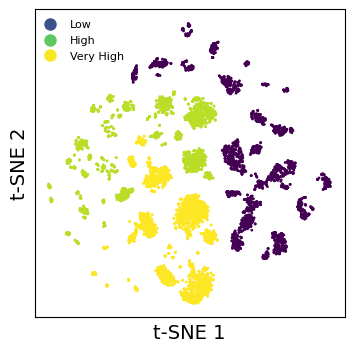

In [9]:
print(bins)
print(labelmap)
# plot_cluster(data_df)
plot_cluster(data_df, save_name = './figures/stratified_cluster.pdf')

SURVIVAL, FULL DATASET


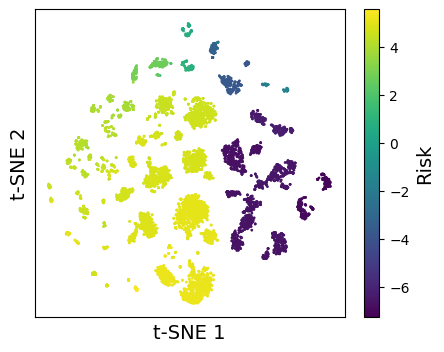

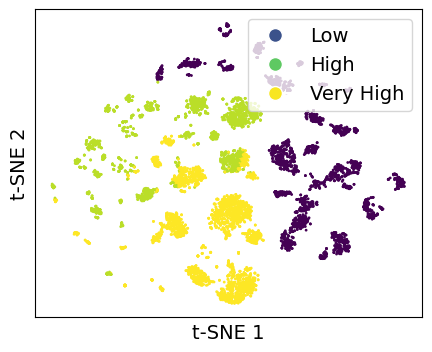

plot_tsne(X_tsne, predictions, labels, survival=True, subset_labels=subset_labels)


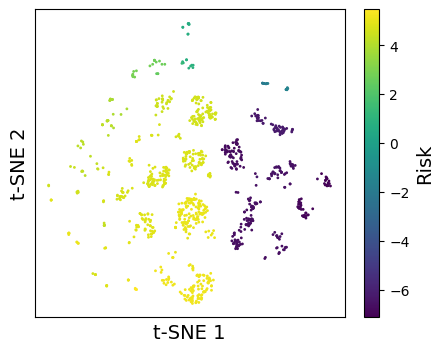

plot_tsne(X_tsne, predictions, labels, detailed = detailed, survival=False, subset_labels=["Endometrial Cancer"])


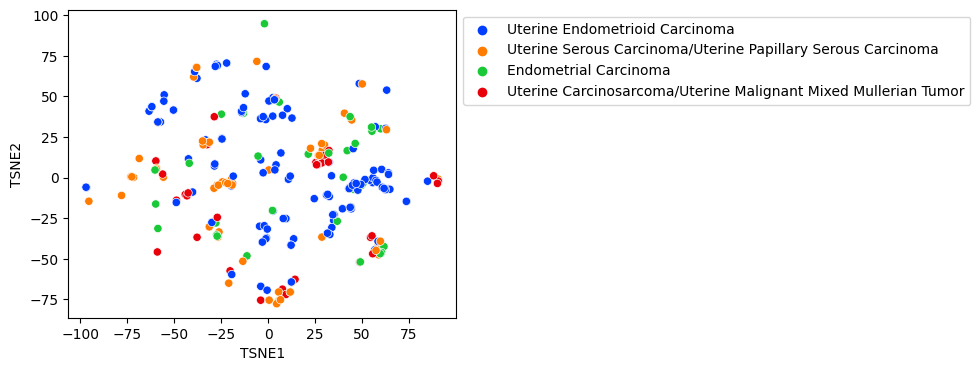

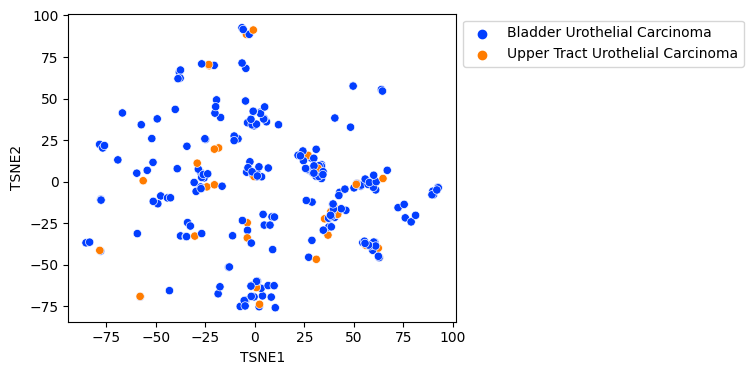

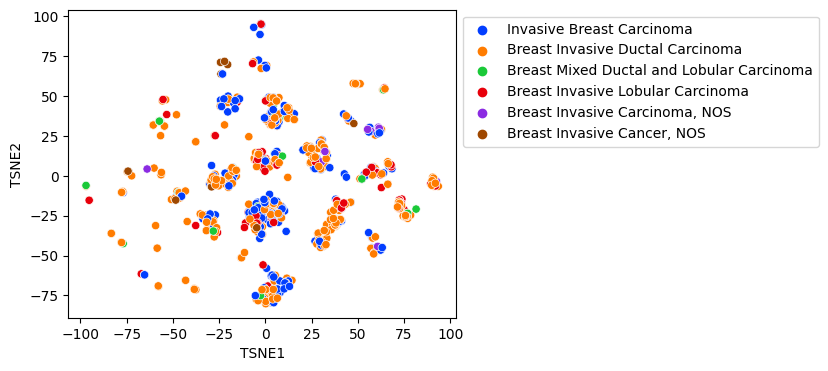

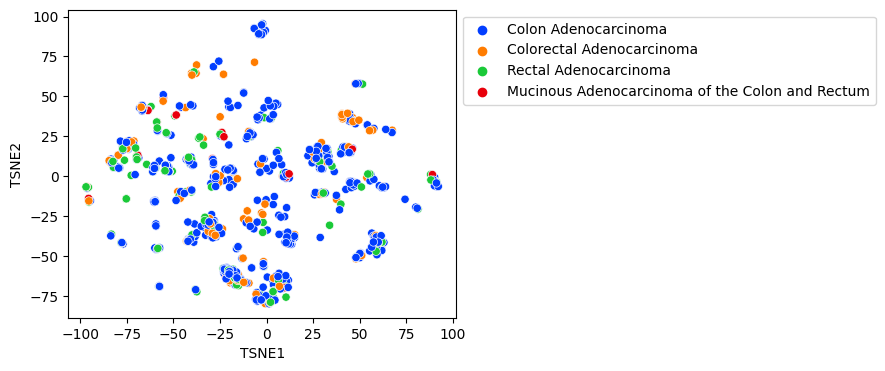

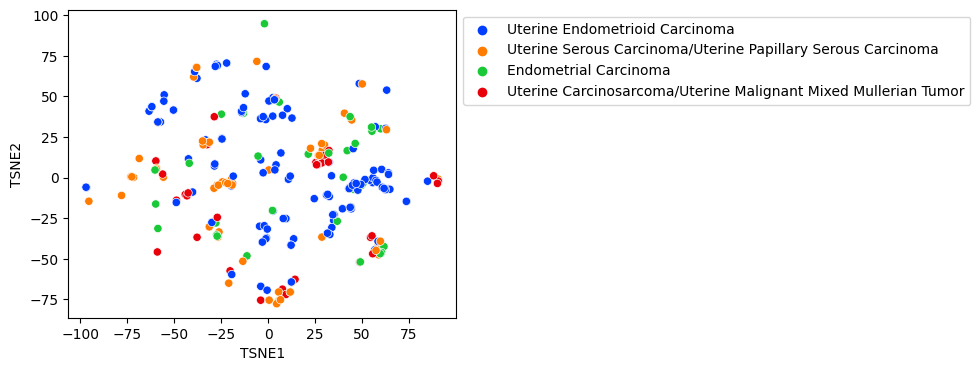

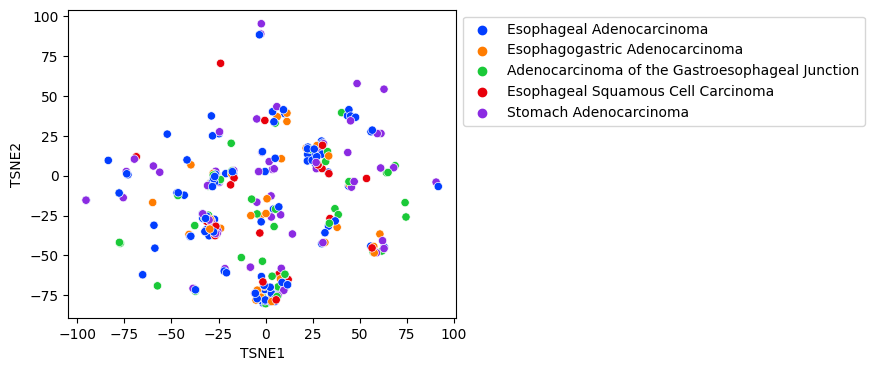

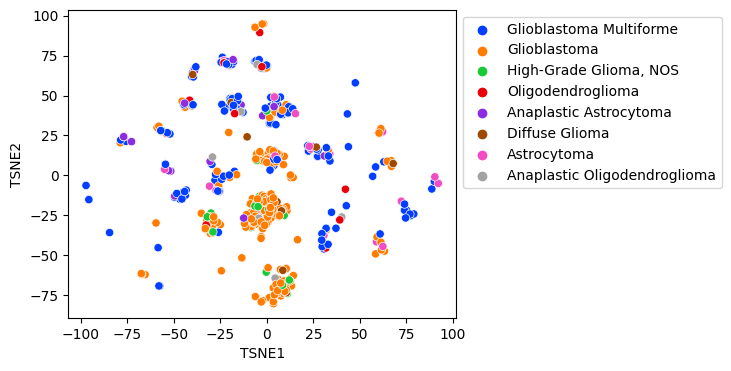

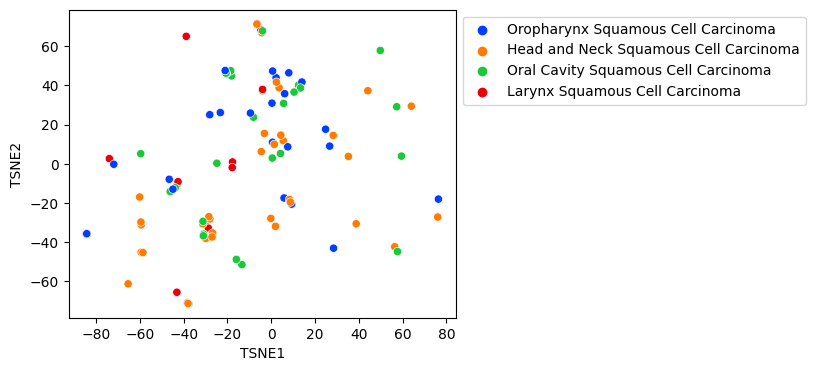

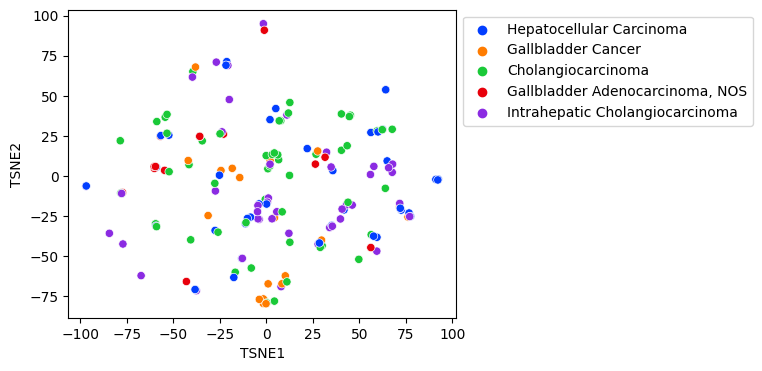

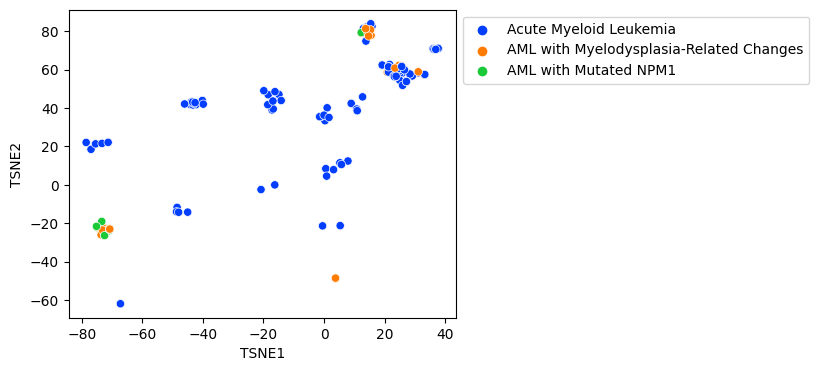

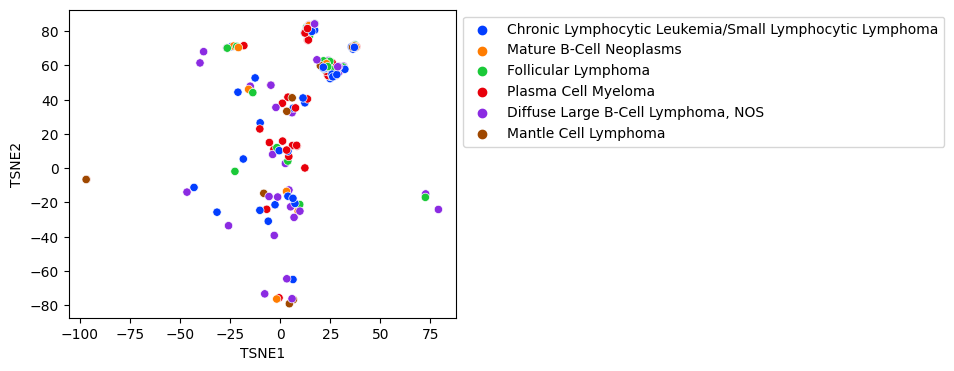

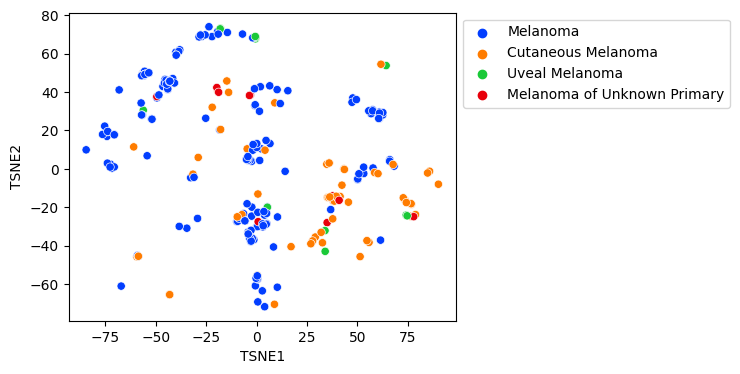

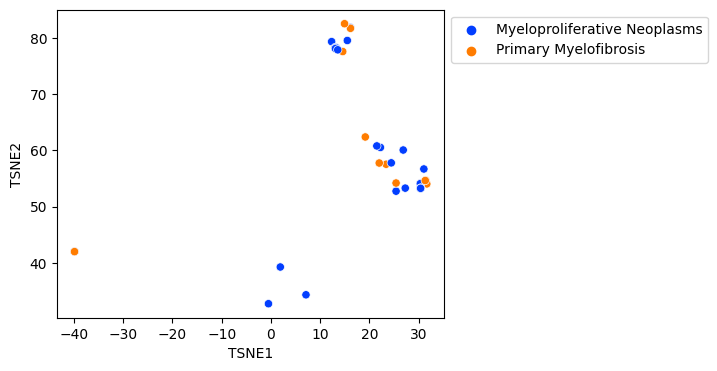

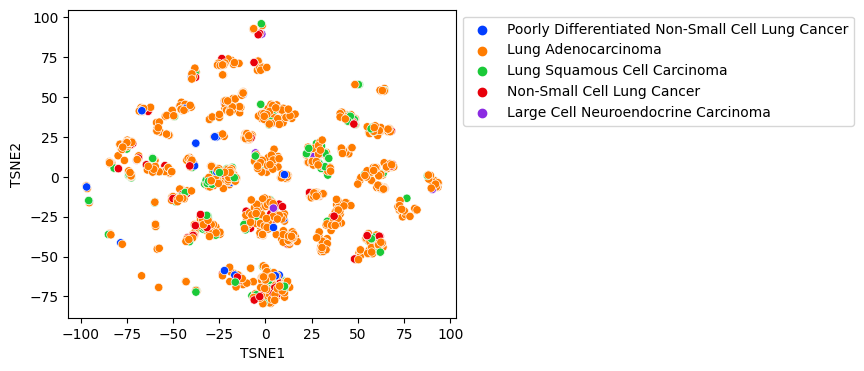

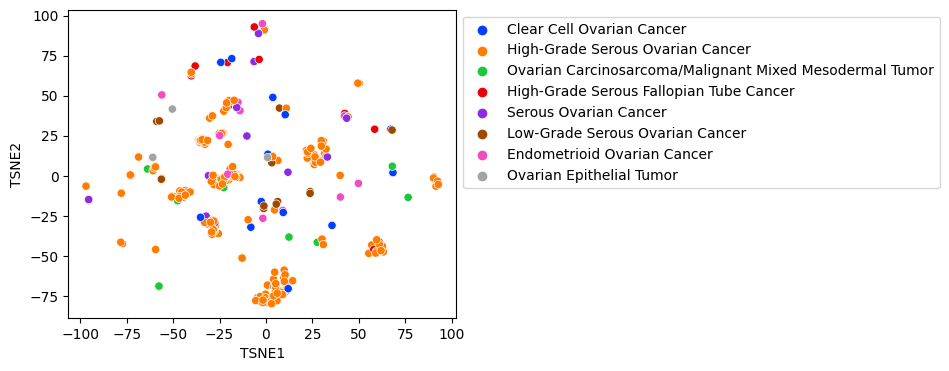

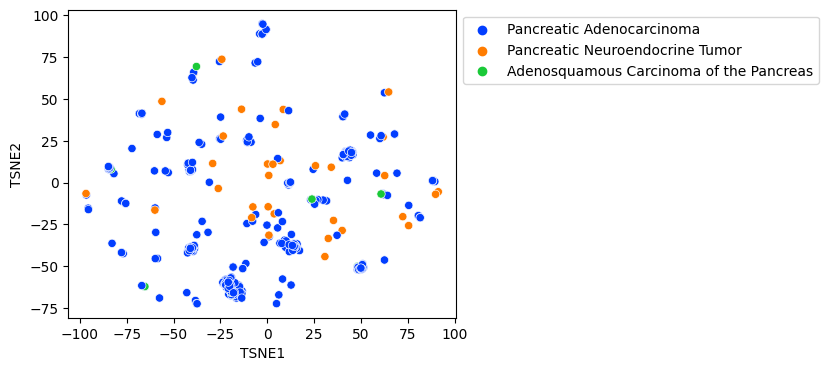

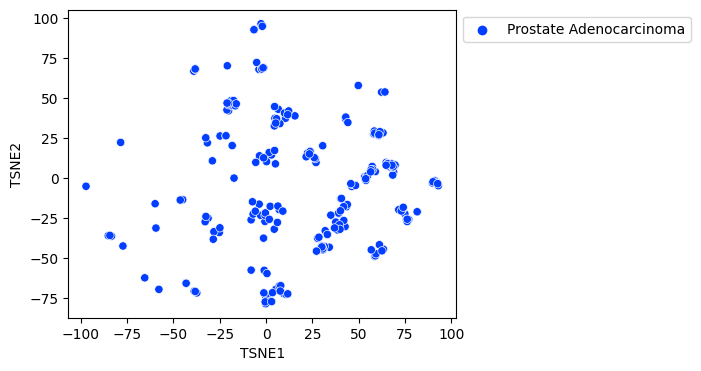

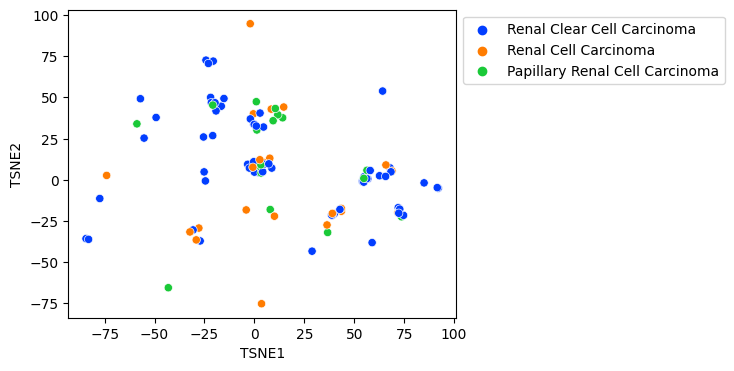

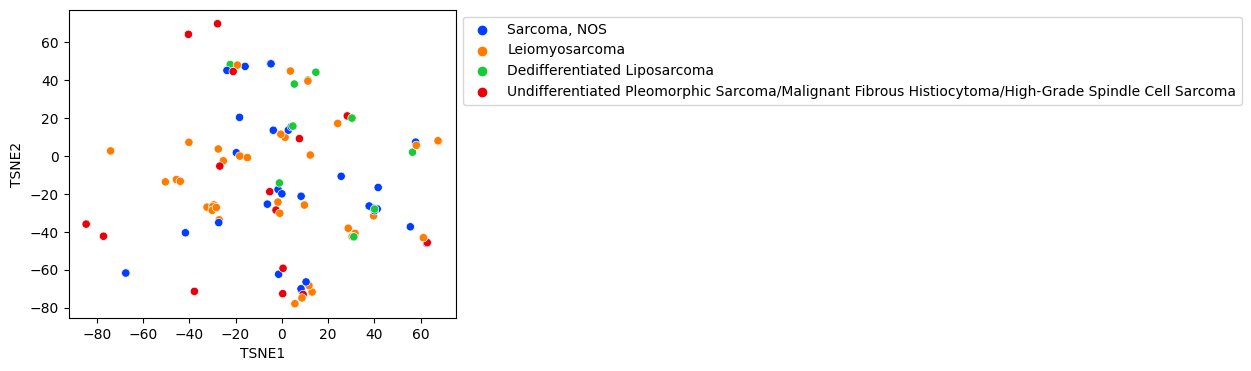

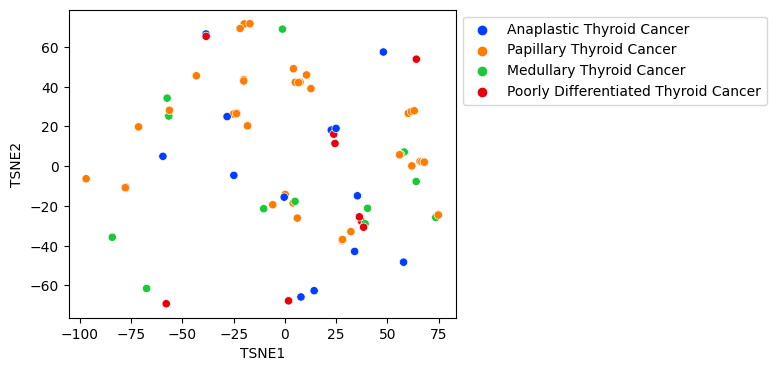

plot_tsne(X_tsne, predictions, labels, survival=False)


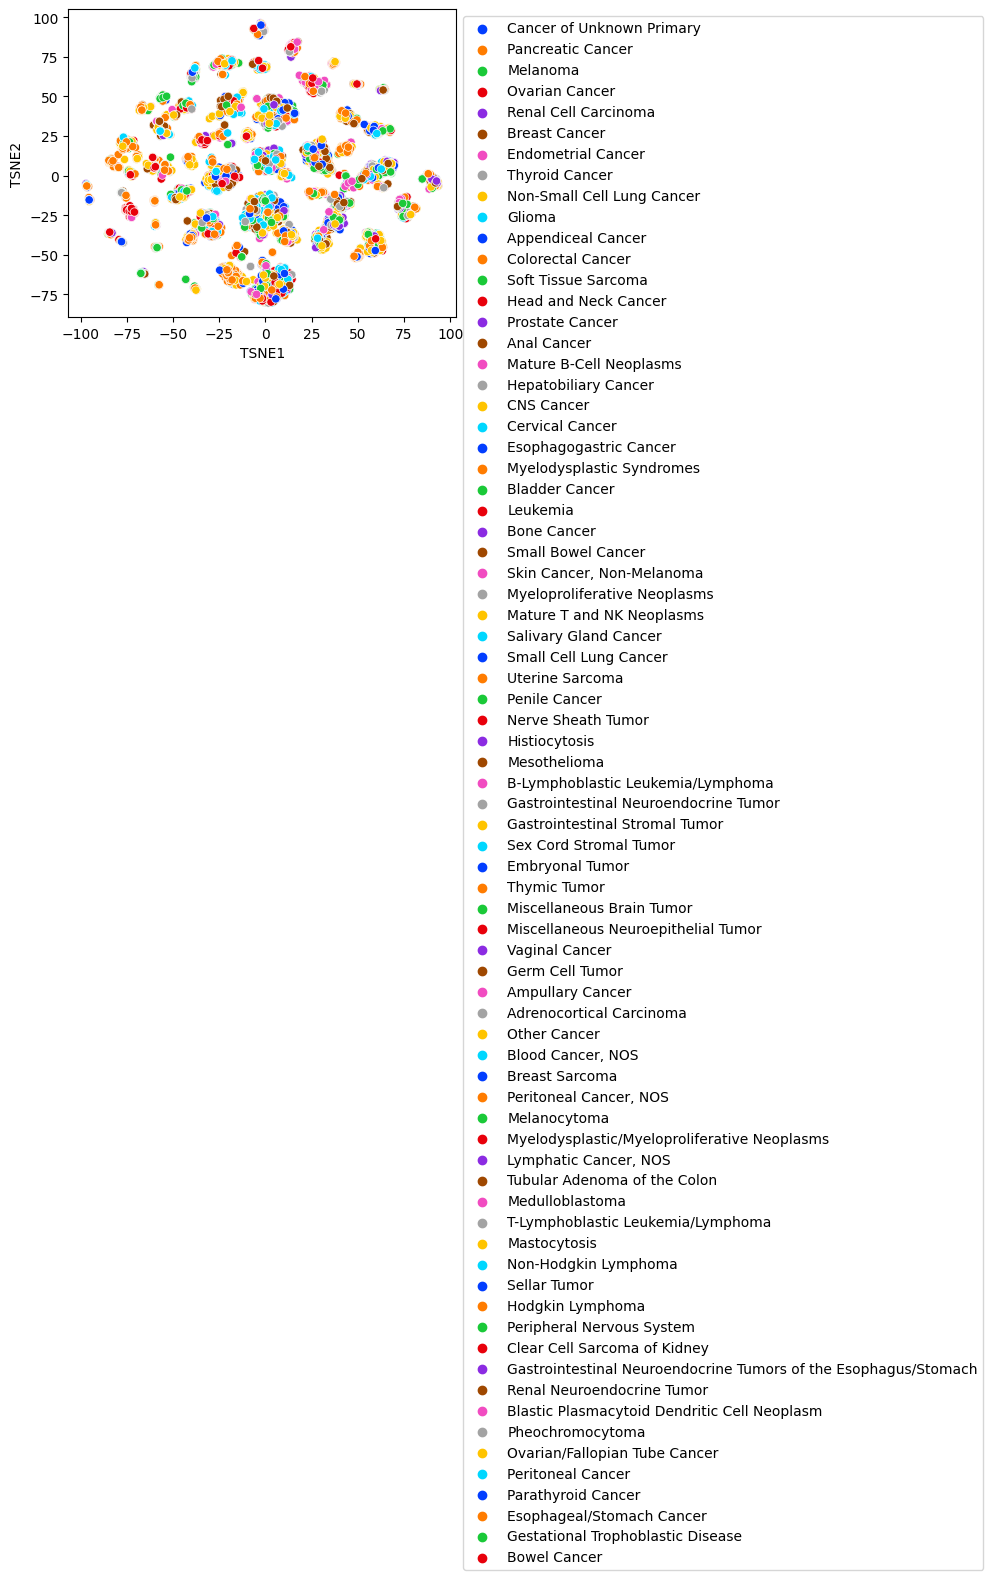

plot_tsne(X_tsne, predictions, labels, survival=False, subset_labels=subset_labels)


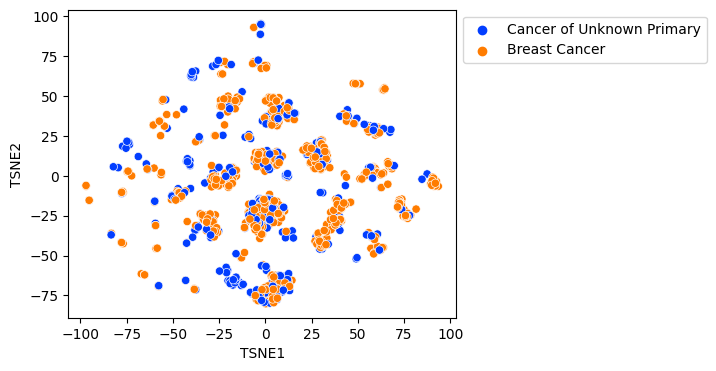

In [11]:
metric,embeddings,predictions,time_event,labels,detailed, X_tsne  = output[('somatt','survival')]

print("SURVIVAL, FULL DATASET")
plot_tsne(X_tsne, predictions, labels, survival=True, save_name='./figures/survival_full.pdf')

subset_labels = ['Breast Cancer', 'Cancer of Unknown Primary']
bins = create_exponential_ranges(min(predictions), max(predictions), 3)
plot_tsne(X_tsne, predictions, labels, survival=True, stratify = bins, save_name='./figures/stratified.pdf')
print('plot_tsne(X_tsne, predictions, labels, survival=True, subset_labels=subset_labels)')
plot_tsne(X_tsne, predictions, labels, survival=True, subset_labels=subset_labels)
print('plot_tsne(X_tsne, predictions, labels, detailed = detailed, survival=False, subset_labels=["Endometrial Cancer"])')
plot_tsne(X_tsne, predictions, labels, detailed = detailed, survival=False, subset_labels=['Endometrial Cancer'])

for i in top99:
    plot_tsne(X_tsne, predictions, labels, detailed = detailed, survival=False, subset_labels=[i])

print('plot_tsne(X_tsne, predictions, labels, survival=False)')
plot_tsne(X_tsne, predictions, labels, survival=False)
print('plot_tsne(X_tsne, predictions, labels, survival=False, subset_labels=subset_labels)')
plot_tsne(X_tsne, predictions, labels, survival=False, subset_labels=subset_labels)

# print("TUMOR TYPE")
# metric,embeddings,predictions,labels,detailed, X_tsne  = output[('somatt','tumortype')]
# plot_tsne(X_tsne, predictions, labels, survival=False)
# plot_tsne(X_tsne, predictions, labels, survival=False, subset_labels=subset_labels)

# print("TUMOR TYPE, SUBSET 1 PERCENT")
# metric,embeddings,predictions,labels,detailed, X_tsne  = output[('somatt','tumortype1')]
# print(np.unique(labels))
# plot_tsne(X_tsne, predictions, labels, survival=False)
# plot_tsne(X_tsne, predictions, labels, survival=False, subset_labels=subset_labels)
# plot_tsne(X_tsne, predictions, labels, detailed = detailed, survival=False, subset_labels=['Endometrial Cancer'])

/home/dandreas/.conda/envs/deepV_a100/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fef93db5240>
Traceback (most recent call last):
  File "/home/dandreas/.conda/envs/deepV_a100/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/dandreas/.conda/envs/deepV_a100/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/dandreas/.conda/envs/deepV_a100/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.versio

60


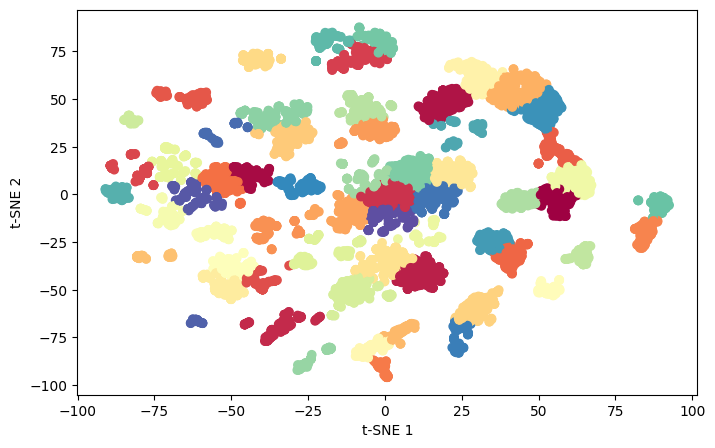

In [26]:

metric,embeddings,predictions,time_event,labels,detailed, X_tsne  = output[('somatt','survival')]
# plot_tsne(X_tsne, predictions, labels, survival=True)
kmeans = KMeans(n_clusters=60, random_state=0)
labels = kmeans.fit_predict(X_tsne)
print(len(np.unique(labels)))
plt.figure(figsize=(8, 5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='Spectral')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
# plt.colorbar()
# plt.title(f'SNN {i,j} Clustering on t-SNE Data')
plt.savefig('./figures/kmeans60_clusters.pdf')
plt.show()  

# snn = pickleLoad('snn_labs.pkl')

# for i in [9]:
#     for j in [10,11,12,13,14,15]:
#         labs = snn[(i,j)]
#         print(len(np.unique(labs)))
#         plt.figure(figsize=(8, 5))
#         plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labs, cmap='Spectral')
#         plt.colorbar()
#         plt.title(f'SNN {i,j} Clustering on t-SNE Data')
#         plt.show()    

In [17]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, accuracy_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.preprocessing import label_binarize

def getClassAucs_fromDF(df,logits,label_map, binary=False):
    # Extract predictions and labels from the DataFrame
    labels = df['int_label'].to_numpy()
    nlabels = len(np.unique(labels))
    if type(logits)==list: logits = np.array(logits)
    aucs = []
    auprcs = []

    target_bin = label_binarize(labels, classes=np.arange(nlabels))
    for i in range(nlabels):
        auc_ = roc_auc_score(target_bin[:, i], logits[:, i])
        precision, recall, _ = precision_recall_curve(target_bin[:, i], logits[:, i])
        auprc = auc(recall, precision)
        label = label_map[i]
        aucs.append([label, auc_])
        auprcs.append([label, auprc])
        
    # Convert results to DataFrames
    prefix = 'binary ' if binary else 'somatt '
    aucs_df = pd.DataFrame(aucs, columns=['target', prefix+'auc'])
    auprcs_df = pd.DataFrame(auprcs, columns=['target', prefix+'auprc'])

    aucs_df = aucs_df[aucs_df['target'] != 'Cancer of Unknown Primary']
    auprcs_df = auprcs_df[auprcs_df['target'] != 'Cancer of Unknown Primary']
    
    return aucs_df, auprcs_df, target_bin

def calculate_metrics(df, preds, nlabels=None, plot_auc=False, plot_auprc=False):
    labels = df['int_label'].to_numpy()
    classes = np.unique(labels) if nlabels is None else np.arange(nlabels)
    labels_binarize = label_binarize(labels, classes=classes)
    preds_binary = df['int_pred'].to_numpy()
    preds = torch.tensor(preds,dtype=torch.float32)
    # preds_binary = label_binarize(preds_int, classes=np.arange(preds.shape[1]))
        # Find classes that are present in the labels
    present_classes = np.unique(labels)
    if len(present_classes) < len(classes): print('Missing classes:', set(classes) - set(present_classes))
    # Remove columns in preds and labels_binarize that correspond to missing classes
    valid_class_indices = np.isin(classes, present_classes)
    
    # Filter the predictions and labels_binarize based on valid classes
    labels_binarize = labels_binarize[:, valid_class_indices]
    preds = preds[:, valid_class_indices]
    
    def get_metrics(labels, preds, preds_binary):
        accuracy = accuracy_score(labels, preds_binary)
        precision = precision_score(labels, preds_binary, average='macro')
        recall = recall_score(labels, preds_binary, average='macro')
        f1 = f1_score(labels, preds_binary, average='macro')
        auc_ = roc_auc_score(labels_binarize, preds, average='macro', multi_class = 'ovr')
        # precision_, recall_, _ = precision_recall_curve(labels, preds)
        # auprc = auc(recall_, precision_)
        # fpr, tpr, _ = roc_curve(labels, preds)
        # roc_auc = auc(fpr, tpr)
        return accuracy, precision, recall, f1, auc_#, auprc, fpr, tpr, roc_auc, precision_, recall_

    # accuracy, precision, recall, f1, auc_, auprc, fpr, tpr, roc_auc, precision_, recall_ = get_metrics(labels, preds, preds_binary)
    accuracy, precision, recall, f1, auc_ = get_metrics(labels, preds, preds_binary)

    # if plot_auc:
    #     plt.figure()
    #     plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    #     plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    #     plt.xlim([0.0, 1.0])
    #     plt.ylim([0.0, 1.05])
    #     plt.xlabel('False Positive Rate')
    #     plt.ylabel('True Positive Rate')
    #     plt.title('Receiver Operating Characteristic (ROC) Curve')
    #     plt.legend(loc='lower right')
    #     plt.show()

    # if plot_auprc:
    #     plt.figure(figsize=(8, 6))
    #     plt.plot(recall_, precision_, color='blue', lw=2, label=f'GNN (area = {auprc:.2f})')
    #     plt.xlabel('Recall', fontsize = 14)
    #     plt.ylabel('Precision', fontsize = 14)
    #     # plt.title('Precision-Recall (PR) Curve')
    #     plt.legend(loc='lower left')
    #     # plt.savefig('pr_curve.pdf')
    #     plt.show()

    return accuracy, precision, recall, f1, auc_#, auprc, fpr, tpr, roc_auc, precision_, recall_

In [18]:
def getdf(p,l,d,label_map):
    df=pd.DataFrame({'predictions':p,'labels':l,'detailed':d})
    m = {i:j for j,i in label_map.items()}
    df['int_label'] = df['labels'].map(m)
    df['int_pred'] = df['predictions'].map(m)
    return df

In [19]:
loaders_binary =        lambda x: getTrainTestLoaders(x, batch_size = 500, return_indices=True)
print(labeled_data[4])
data_df_ = pd.read_csv(data_dir+labeled_data[4])
nlabels = len(data_df_['CANCER_TYPE_INT'].unique())
print('nlabels:',nlabels)
dataset_bin = Dataset_Binary(data_df_, 'CANCER_TYPE_INT', 'cpu')
_, _, _, test_indices = loaders_binary(dataset_bin)
data_df_test = data_df_.iloc[test_indices]
data_df_test.reset_index(drop=True, inplace=True)

metric,embeddings,predictions,logits_som,label_map,labels,detailed,X_tsne  = output[('somatt','tumortype1')]
somatt_tumortype = getdf(predictions,labels,detailed,label_map)
somatt_tumortype = pd.concat([data_df_test, somatt_tumortype],axis=1)
auc_som, auprc_som, _ = getClassAucs_fromDF(somatt_tumortype, logits_som, label_map)

data_1_00percentMinCancerType.csv
nlabels: 20
145518 samples


In [20]:
metric,embeddings,predictions,logits_bin,label_map,labels,detailed,X_tsne = output[('binary','tumortype1')]
binary_tumortype = getdf(predictions,labels,detailed,label_map)
binary_tumortype = pd.concat([data_df_test, binary_tumortype],axis=1)
auc_bin, auprc_bin, _ = getClassAucs_fromDF(binary_tumortype, logits_bin,label_map, binary=True)

In [21]:
from functools import reduce
dfs = [auc_som, auc_bin, auprc_som, auprc_bin]
df = pd.merge(auc_som, auc_bin, on='target', how='outer')
df = pd.merge(df, auprc_som, on='target', how='outer')
df = pd.merge(df, auprc_bin, on='target', how='outer')

In [22]:
for i in df['target'].values:
    print(f'"{i}",')
df

"Bladder Cancer",
"Breast Cancer",
"Colorectal Cancer",
"Endometrial Cancer",
"Esophagogastric Cancer",
"Glioma",
"Head and Neck Cancer",
"Hepatobiliary Cancer",
"Leukemia",
"Mature B-Cell Neoplasms",
"Melanoma",
"Myeloproliferative Neoplasms",
"Non-Small Cell Lung Cancer",
"Ovarian Cancer",
"Pancreatic Cancer",
"Prostate Cancer",
"Renal Cell Carcinoma",
"Soft Tissue Sarcoma",
"Thyroid Cancer",


,target,somatt auc,binary auc,somatt auprc,binary auprc
0,Bladder Cancer,0.898032,0.875078,0.568566,0.428417
1,Breast Cancer,0.902212,0.869877,0.703737,0.590225
2,Colorectal Cancer,0.938555,0.920182,0.795353,0.698325
3,Endometrial Cancer,0.918116,0.907731,0.588793,0.520944
4,Esophagogastric Cancer,0.748649,0.720489,0.112503,0.077854
5,Glioma,0.932095,0.885932,0.706859,0.513098
6,Head and Neck Cancer,0.760413,0.752638,0.078776,0.038668
7,Hepatobiliary Cancer,0.728121,0.673630,0.130344,0.069965
8,Leukemia,0.980038,0.958420,0.691185,0.553430
9,Mature B-Cell Neoplasms,0.972254,0.937281,0.779094,0.632638


In [23]:
top99 = ["Bladder Cancer",
"Breast Cancer",
"Colorectal Cancer",
"Endometrial Cancer",
"Esophagogastric Cancer",
"Glioma",
"Head and Neck Cancer",
"Hepatobiliary Cancer",
"Leukemia",
"Mature B-Cell Neoplasms",
"Melanoma",
"Myeloproliferative Neoplasms",
"Non-Small Cell Lung Cancer",
"Ovarian Cancer",
"Pancreatic Cancer",
"Prostate Cancer",
"Renal Cell Carcinoma",
"Soft Tissue Sarcoma",
"Thyroid Cancer"]

In [24]:
accuracy, precision, recall, f1, auc_ = calculate_metrics(somatt_tumortype, logits_som)
df_all = pd.DataFrame({'Metric': ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC'], 'SoMatt': [accuracy, precision, recall, f1, auc_]})

/tmp/ipykernel_2479597/2219938218.py:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  preds = torch.tensor(preds,dtype=torch.float32)


In [25]:
accuracy, precision, recall, f1, auc_ = calculate_metrics(binary_tumortype, logits_bin)
df_all['Binary'] = [accuracy, precision, recall, f1, auc_]
df_all

,Metric,SoMatt,Binary
0,Accuracy,0.593870,0.532367
1,Precision,0.554473,0.480166
2,Recall,0.515220,0.448463
3,F1,0.522174,0.452739
4,AUC,0.869479,0.846355


<Figure size 400x400 with 0 Axes>

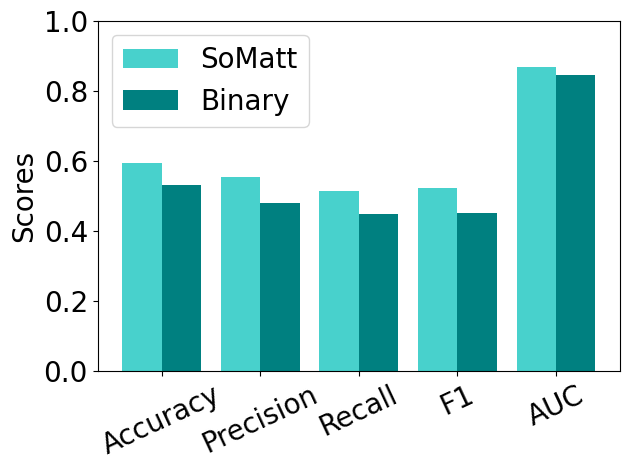

In [26]:
df_all
plt.figure(figsize=(4, 4)) 
df_all.plot(x='Metric', kind='bar', width=0.8, color = ['mediumturquoise','teal'])
fs = 20
# Customize plot
plt.xlabel('')
plt.ylabel('Scores', fontsize=fs)
plt.xticks(rotation=25, fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylim((0,1))
# plt.legend(title='Model', bbox_to_anchor=(1, 1))
plt.legend(loc='upper left', fontsize=fs)

# Display the plot
plt.tight_layout()
plt.savefig('./figures/tumortype_metrics.pdf', bbox_inches='tight')
plt.show()

In [27]:
assays_ = somatt_tumortype['assay'].unique()
vc = somatt_tumortype['assay'].value_counts()
vcd = {}
vcc = {}
# print('Assay\t\t\tCount\tN Genes')
for i,j in zip(vc.index,vc):
    vcd[i] = len(assays[i])
    vcc[i] = j
    # print(i,'\t\t',j,len(assays[i]))
somatt_tumortype['n_genes'] = somatt_tumortype['assay'].map(vcd)
m = np.median(list(vcd.values()))

high = [k for k,v in vcd.items() if v > 300]
low = [k for k,v in vcd.items() if v <= 30]

highc = sum([v for k,v in vcc.items() if k in high])
lowc = sum([v for k,v in vcc.items() if k in low])

print(highc,lowc)
# np.sort(somatt_tumortype['n_genes'].unique())

22283 470


In [30]:
dh = somatt_tumortype[somatt_tumortype['assay'].isin(high)]
bh = binary_tumortype[binary_tumortype['assay'].isin(high)]

dl = somatt_tumortype[somatt_tumortype['assay'].isin(low)]
bl = binary_tumortype[binary_tumortype['assay'].isin(low)]

accuracy, precision, recall, f1, auc_ = calculate_metrics(dh, np.array(logits_som)[dh.index], nlabels=nlabels)
df_all_high = pd.DataFrame({'Metric': ['Precision', 'F1'], 'SoMatt': [precision, f1]})
accuracy, precision, recall, f1, auc_ = calculate_metrics(bh, np.array(logits_bin)[bh.index], nlabels=nlabels)
df_all_high['Binary'] = [precision, f1]

accuracy, precision, recall, f1, auc_ = calculate_metrics(dl, np.array(logits_som)[dl.index], nlabels=nlabels)
df_all_low = pd.DataFrame({'Metric': ['Precision', 'F1'], 'SoMatt': [ precision, f1]})
accuracy, precision, recall, f1, auc_ = calculate_metrics(bl, np.array(logits_bin)[bl.index], nlabels=nlabels)
df_all_low['Binary'] = [precision,  f1]


Missing classes: {9, 10, 18, 12}
Missing classes: {9, 10, 18, 12}


/home/dandreas/.conda/envs/deepV_a100/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dandreas/.conda/envs/deepV_a100/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dandreas/.conda/envs/deepV_a100/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


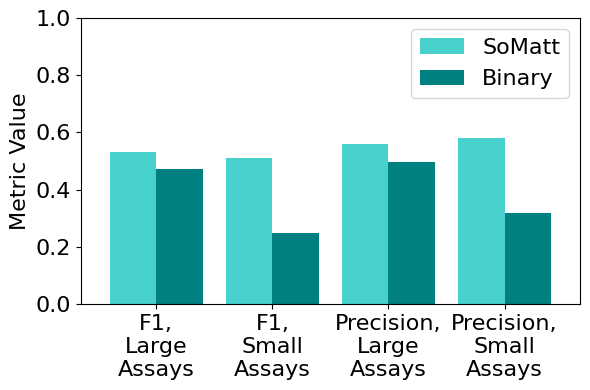

In [102]:
# # print('ALL')
# # print(df_all)
# print('\nHIGH')
# print(df_all_high)
# print('\nLOW')
# print(df_all_low)
# print('\n\n')


df_all['Group'] = 'ALL'
df_all_high['Group'] = 'Large\nAssays'
df_all_low['Group'] = 'Small\nAssays'
# Combine the DataFrames
df_combined = pd.concat([df_all_high, df_all_low])

# Combine the 'Metric' and 'Group' into one column for easier comparison
df_combined['Metric_Group'] = df_combined['Metric'] + ',\n' + df_combined['Group']

# Reshape the DataFrame to long format for plotting
df_melted = df_combined.melt(id_vars=['Metric_Group'], value_vars=['Binary', 'SoMatt',], 
                             var_name='Type', value_name='Value')

# Create the pivoted DataFrame so 'Metric_Group' and 'Type' become indices
pivot_df = df_melted.pivot_table(index=['Metric_Group'], columns='Type', values='Value').reset_index()
pivot_df = pivot_df[['Metric_Group','SoMatt','Binary']]

# Plot the chart
fig, ax = plt.subplots(figsize=(6, 4))
fs=16
# Plot grouped bar chart for each Metric_Group and Type
pivot_df.set_index('Metric_Group').plot(kind='bar', ax=ax, fontsize=fs, color = ['mediumturquoise','teal'], width=.8)

# Add labels and title
ax.set_ylabel('Metric Value',fontsize=fs)
ax.set_xlabel('')
ax.set_ylim(0, 1)
ax.legend(fontsize=fs)
# Rotate x labels for better readability
plt.xticks(rotation=0, ha='center')

# Adjust layout
plt.tight_layout()
plt.savefig('./figures/small_vs_large_assays.pdf', bbox_inches='tight')
# Show plot
plt.show()



In [12]:
loaders_binary =        lambda x: getTrainTestLoaders(x, batch_size = 500, return_indices=True)

print(labeled_data[0])
data_df = pd.read_csv(data_dir+labeled_data[0])

dataset_bin = Dataset_Binary_Survival(data_df, 'cpu')
_, _, _, test_indices = loaders_binary(dataset_bin)
data_df_test = data_df.iloc[test_indices]
data_df_test.reset_index(drop=True, inplace=True)

metric,embeddings,predictions_som,time_event,labels,detailed, X_tsne  = output[('somatt','survival')]
somatt_survival = df=pd.DataFrame({'pred':predictions_som,'label':labels,'detailed':detailed,'Time':time_event['Time'],'Event':time_event['Event']})
somatt_survival = pd.concat([data_df_test, somatt_survival],axis=1)

data_0_00_survival_ratio1.csv
43338 samples
41481 unique patients
90 cancer types
626 detailed cancer types


In [13]:
metric,embeddings,predictions_bin,time_event,labels,detailed, X_tsne = output[('binary','survival')]
binary_survival = pd.DataFrame({'pred':predictions_bin,'label':labels,'detailed':detailed,'Time':time_event['Time'],'Event':time_event['Event']})
binary_survival = pd.concat([data_df_test, binary_survival],axis=1)

In [14]:
assays_ = somatt_survival['assay'].unique()
vc = somatt_survival['assay'].value_counts()
vcd = {}
vcc = {}
# print('Assay\t\t\tCount\tN Genes')
for i,j in zip(vc.index,vc):
    vcd[i] = len(assays[i])
    vcc[i] = j
    # print(i,'\t\t',j,len(assays[i]))
somatt_survival['n_genes'] = somatt_survival['assay'].map(vcd)
m = np.median(list(vcd.values()))

high = [k for k,v in vcd.items() if v > 300]
low = [k for k,v in vcd.items() if v <= 50]

highc = sum([v for k,v in vcc.items() if k in high])
lowc = sum([v for k,v in vcc.items() if k in low])

print(highc,lowc)

5934 853


In [15]:
def calculate_c_index(df, preds):
    all_times = df['Time'].to_numpy()
    all_events = df['Event'].to_numpy()
    survival = np.column_stack((all_times, all_events))
    c_index_value = c_index(np.array(preds), survival)
    return c_index_value

dh = somatt_survival[somatt_survival['assay'].isin(high)]
bh = binary_survival[binary_survival['assay'].isin(high)]

dl = somatt_survival[somatt_survival['assay'].isin(low)]
bl = binary_survival[binary_survival['assay'].isin(low)]

c_index_ = calculate_c_index(dh, np.array(predictions_som)[dh.index])
df_all_high = pd.DataFrame({'Metric': ['C-Index'], 'SoMatt': [c_index_]})
c_index_ = calculate_c_index(bh, np.array(predictions_bin)[bh.index])
df_all_high['Binary'] = [c_index_]

c_index_ = calculate_c_index(dl, np.array(predictions_som)[dl.index])
df_all_low = pd.DataFrame({'Metric': ['C-Index'], 'SoMatt': [c_index_]})
c_index_ = calculate_c_index(bl, np.array(predictions_bin)[bl.index])
df_all_low['Binary'] = [c_index_]


HIGH
    Metric    SoMatt    Binary
0  C-Index  0.818746  0.782566

LOW
    Metric   SoMatt    Binary
0  C-Index  0.58882  0.565871



    Metric Group    Type     Value
0  C-Index  HIGH  SoMatt  0.818746
1  C-Index   LOW  SoMatt  0.588820
2  C-Index  HIGH  Binary  0.782566
3  C-Index   LOW  Binary  0.565871


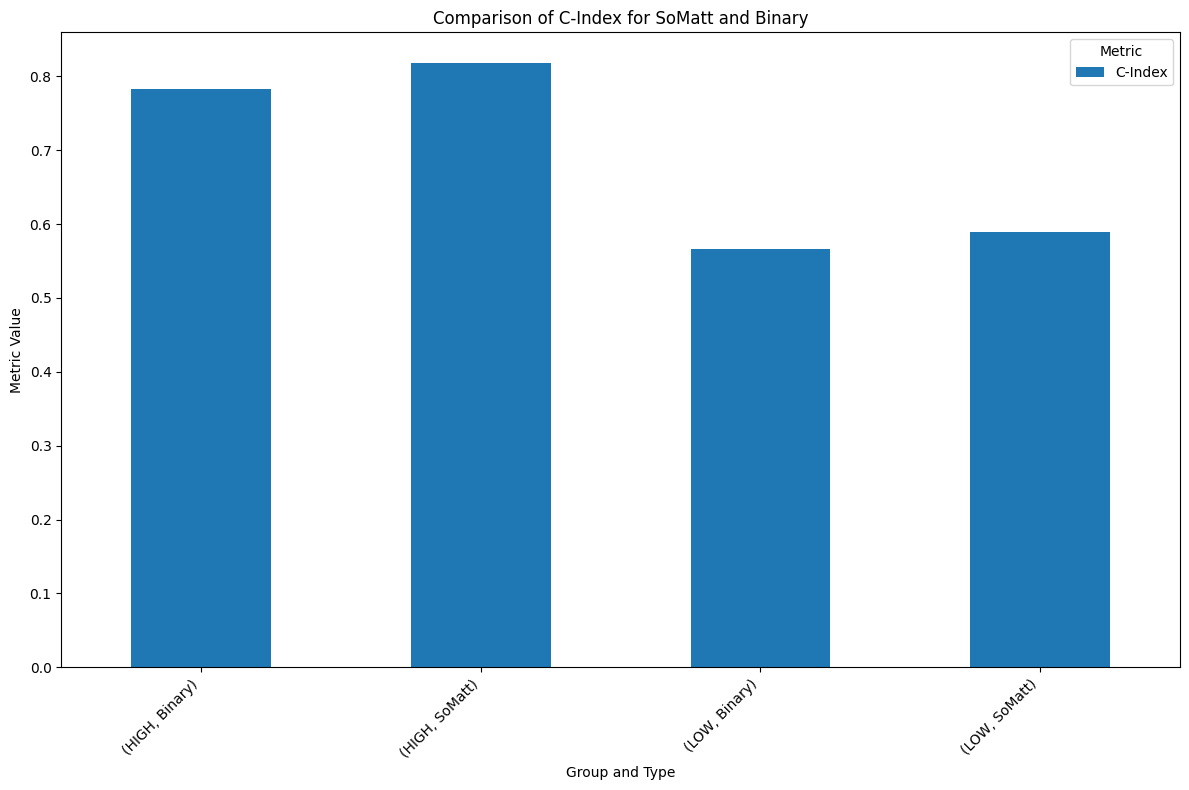

In [16]:
print('\nHIGH')
print(df_all_high)
print('\nLOW')
print(df_all_low)
print('\n\n')

df_all_high['Group'] = 'HIGH'
df_all_low['Group'] = 'LOW'
# Combine the DataFrames
df_combined = pd.concat([df_all_high, df_all_low])

# Reshape the DataFrame to long format for easier plotting
df_melted = df_combined.melt(id_vars=['Metric', 'Group'], value_vars=['SoMatt', 'Binary'], 
                             var_name='Type', value_name='Value')
print(df_melted)
# Plot the bar chart
# Pivot the dataframe to have 'Group', 'Type', and 'Metric' as indices, and 'Value' as the value column
pivot_df = df_melted.pivot_table(index=['Group', 'Type'], columns='Metric', values='Value').reset_index()

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot grouped bar chart for each metric: Accuracy, Precision, Recall, F1
pivot_df.set_index(['Group', 'Type']).plot(kind='bar', ax=ax)

# Add labels and title
ax.set_xlabel('Group and Type')
ax.set_ylabel('Metric Value')
ax.set_title('Comparison of C-Index for SoMatt and Binary')

# Rotate x labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout
plt.tight_layout()
plt.show()
